In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.typing import ArrayLike
from sklearn.datasets import (
    fetch_california_housing,
    load_breast_cancer,
    load_diabetes,
    load_iris,
    load_wine,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.linear_model import Lasso, LogisticRegression, LinearRegression, Ridge
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

In [2]:
SEED = 21031248


def set_seed() -> None:
    """To make full reproducibility"""
    random.seed(SEED)
    np.random.seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)


set_seed()

In [3]:
def regression_report(
    y_true: ArrayLike, y_pred: ArrayLike, num_feach=1
) -> pd.DataFrame:
    """Regression report
    Parameters:
    y_true : array-like, shape (n_samples,)
        True values.
    y_pred : array-like, shape (n_samples,)
        Predicted values.
    Returns:
    report : pd.DataFrame
    """

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    n = len(y_true)
    p = num_feach
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1) if n > p + 1 else np.nan

    report_data = {
        "Metric": ["MAE", "MSE", "RMSE", "R-sq", "Adj R-sq"],
        "Value": list(map(lambda x: round(x, 2), [mae, mse, rmse, r2, adjusted_r2])),
    }

    report = pd.DataFrame(report_data)
    return report

<h1 style="text-align:center;">Part 1</h1>

### Exercise 1:  Feature Selection with __SelectKBest__

In [4]:
X, y = load_iris(return_X_y=True, as_frame=True)
feature_selector_kbest = SelectKBest(chi2, k=2)
feature_selector_kbest.fit(X, y)
print("Top 2 features selected by Select K best method by chi-square score:")
for feach in feature_selector_kbest.get_feature_names_out():
    print(f"\t{feach}")

Top 2 features selected by Select K best method by chi-square score:
	petal length (cm)
	petal width (cm)


### Exercise 2: Feature Importance with __Random Forest__

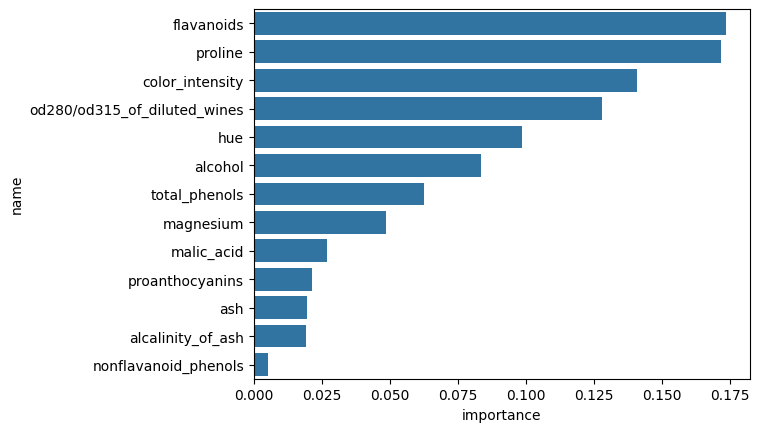

In [5]:
X, y = load_wine(return_X_y=True, as_frame=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

assert (
    X.select_dtypes(exclude=[float, int]).shape[1] == 0
), "features contain non numeric data"
# assert
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

feature_imp_rf = pd.DataFrame(
    {
        "importance": random_forest_model.feature_importances_,
        "name": random_forest_model.feature_names_in_,
    }
).sort_values(by="importance", ascending=False)

sns.barplot(feature_imp_rf, x="importance", y="name")
plt.show()

### Exercise 3: Recursive Feature Elimination (RFE)

In [6]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
scaler = StandardScaler()  # for coefs in SVM we must use standartization
X = pd.DataFrame(scaler.fit_transform(X), columns=scaler.get_feature_names_out())

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)


assert (
    X.select_dtypes(exclude=[float, int]).shape[1] == 0
), "features contain non numeric data"
# i will go with 15
feature_selector_rfe = RFE(
    SVC(kernel="linear"), n_features_to_select=15, importance_getter="coef_"
)
feature_selector_rfe.fit(X_train, y_train)

selected_features = X_train.columns[feature_selector_rfe.support_]
print(f"We selected {selected_features.shape[0]} of {X.shape[1]} features:")
for feach in selected_features:
    print(f"\t{feach}")

We selected 15 of 30 features:
	mean concavity
	mean concave points
	mean fractal dimension
	radius error
	texture error
	area error
	worst radius
	worst texture
	worst perimeter
	worst area
	worst smoothness
	worst compactness
	worst concavity
	worst concave points
	worst symmetry


In [7]:
# with all features
print("WITHOUT FEATURE SELECTION")
model = SVC(kernel="linear")
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)
print(classification_report(y_val, y_val_pred, digits=3))

print("WITH FEATURE SELECTION")
# with feature selection
model = SVC(kernel="linear")
model.fit(X_train[selected_features], y_train)
y_val_pred = model.predict(X_val[selected_features])

print(classification_report(y_val, y_val_pred, digits=3))

WITHOUT FEATURE SELECTION
              precision    recall  f1-score   support

           0      0.956     0.935     0.945        46
           1      0.969     0.979     0.974        97

    accuracy                          0.965       143
   macro avg      0.962     0.957     0.960       143
weighted avg      0.965     0.965     0.965       143

WITH FEATURE SELECTION
              precision    recall  f1-score   support

           0      0.956     0.935     0.945        46
           1      0.969     0.979     0.974        97

    accuracy                          0.965       143
   macro avg      0.962     0.957     0.960       143
weighted avg      0.965     0.965     0.965       143



Wow, it is actually better with fewer features

### Exercise 4: L1 Regularization for Feature Selection

In [8]:
X, y = load_diabetes(return_X_y=True, as_frame=True)
scaler = StandardScaler()  # for coefs in lasso we must use standartization
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

assert (
    X.select_dtypes(exclude=[float, int]).shape[1] == 0
), "features contain non numeric data"
# assert
lasso_model = Lasso(alpha=2, max_iter=10**6, tol=1e-12)
lasso_model.fit(X_train, y_train)

selected_features_l1 = X_train.columns[abs(lasso_model.coef_) > 1e-3]

print(f"We selected {selected_features_l1.shape[0]} of {X.shape[1]} features:")
for feach in selected_features_l1:
    print(f"\t{feach}")

We selected 7 of 10 features:
	sex
	bmi
	bp
	s2
	s3
	s5
	s6


In [9]:
# with all features
print("WITHOUT FEATURE SELECTION")
model = Lasso(max_iter=10**5, tol=1e-6)
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)

print(regression_report(y_val, y_val_pred, num_feach=X_train.shape[1]))

# with feature selection
print("\nWITH FEATURE SELECTION")
model = Lasso(max_iter=10**5, tol=1e-6)
model.fit(X_train[selected_features_l1], y_train)
y_val_pred = model.predict(X_val[selected_features_l1])

print(
    regression_report(
        y_val, y_val_pred, num_feach=X_train[selected_features_l1].shape[1]
    )
)

WITHOUT FEATURE SELECTION
     Metric    Value
0       MAE    40.37
1       MSE  2563.65
2      RMSE    50.63
3      R-sq     0.57
4  Adj R-sq     0.52

WITH FEATURE SELECTION
     Metric    Value
0       MAE    40.41
1       MSE  2569.47
2      RMSE    50.69
3      R-sq     0.57
4  Adj R-sq     0.54


again with feature selection, we have better scores on all metrics 

<h1 style="text-align:center;">Classification Exercises</h1>

### Exercise 1: Logistic Regression

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.93      1.00      0.96        13
           2       1.00      0.93      0.96        14

    accuracy                           0.97        38
   macro avg       0.98      0.98      0.98        38
weighted avg       0.98      0.97      0.97        38



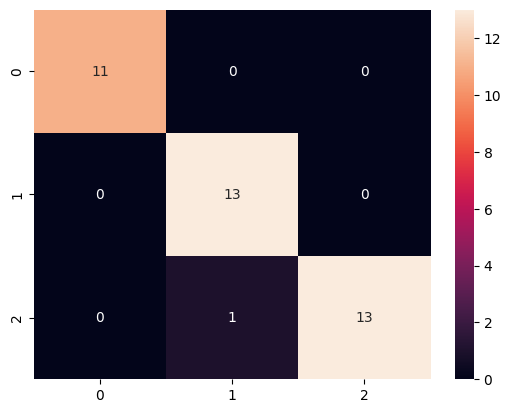

In [10]:
X, y = load_iris(return_X_y=True, as_frame=True)
assert (
    X.select_dtypes(exclude=[float, int]).shape[1] == 0
), "features contain non numeric data"

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

log_reg_clf = LogisticRegression(
    "l2", tol=10e-12, max_iter=1000, class_weight="balanced"
)
log_reg_clf.fit(X_train, y_train)

y_val_pred = log_reg_clf.predict(X_val)

print(classification_report(y_val, y_val_pred))
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True)
plt.show();

### Exercise 2: Support Vector Machine (SVM)

              precision    recall  f1-score   support

           0       0.16      0.18      0.17        61
           1       0.32      0.29      0.31        82

    accuracy                           0.24       143
   macro avg       0.24      0.24      0.24       143
weighted avg       0.25      0.24      0.25       143



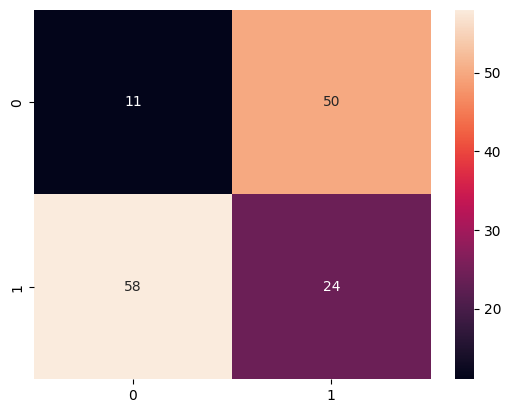

In [11]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
assert (
    X.select_dtypes(exclude=[float, int]).shape[1] == 0
), "features contain non numeric data"

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

svm_clf = SVC(kernel="sigmoid", tol=10e-12, class_weight="balanced")
svm_clf.fit(X_train, y_train)

y_val_pred = svm_clf.predict(X_val)

print(classification_report(y_val, y_val_pred))
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True)
plt.show();

### Exercise 3: Decision Tree Classifier

              precision    recall  f1-score   support

           0       0.92      0.86      0.89        14
           1       0.86      0.67      0.75        18
           2       0.72      1.00      0.84        13

    accuracy                           0.82        45
   macro avg       0.83      0.84      0.83        45
weighted avg       0.84      0.82      0.82        45



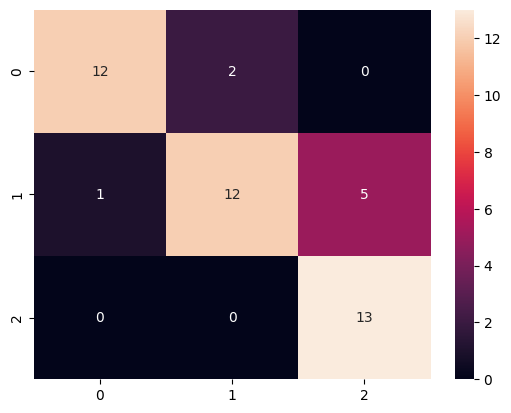

In [12]:
X, y = load_wine(return_X_y=True, as_frame=True)
assert (
    X.select_dtypes(exclude=[float, int]).shape[1] == 0
), "features contain non numeric data"

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

des_tree_clf = DecisionTreeClassifier(
    criterion="gini", min_samples_leaf=0.05, class_weight="balanced"
)
des_tree_clf.fit(X_train, y_train)

y_val_pred = des_tree_clf.predict(X_val)

print(classification_report(y_val, y_val_pred))
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True)
plt.show();

<h1 style="text-align:center;">Regression Exercises</h1>

### Exercise 1: Linear Regression

The Boston housing prices dataset has an ethical problem. So, I fetched the california dataset as sklearn suggested

In [13]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

assert (
    X.select_dtypes(exclude=[float, int]).shape[1] == 0
), "features contain non numeric data"

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

lin_reg = LinearRegression(n_jobs=-1)
lin_reg.fit(X_train, y_train)

y_val_pred = lin_reg.predict(X_val)
print(regression_report(y_val, y_val_pred, num_feach=X.shape[1]))

     Metric  Value
0       MAE   0.53
1       MSE   0.53
2      RMSE   0.73
3      R-sq   0.59
4  Adj R-sq   0.59


### Exercise 2: Ridge Regression

In [14]:
X, y = load_diabetes(return_X_y=True, as_frame=True)
assert (
    X.select_dtypes(exclude=[float, int]).shape[1] == 0
), "features contain non numeric data"

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

ridge_reg = Ridge(tol=10e-12, max_iter=10000)
ridge_reg.fit(X_train, y_train)

y_val_pred = ridge_reg.predict(X_val)

print(regression_report(y_val, y_val_pred, num_feach=X.shape[1]))

     Metric    Value
0       MAE    42.09
1       MSE  2608.59
2      RMSE    51.07
3      R-sq     0.44
4  Adj R-sq     0.38


### Exercise 3: Decision Tree Regression

     Metric  Value
0       MAE   0.51
1       MSE   0.51
2      RMSE   0.71
3      R-sq   0.62
4  Adj R-sq   0.62


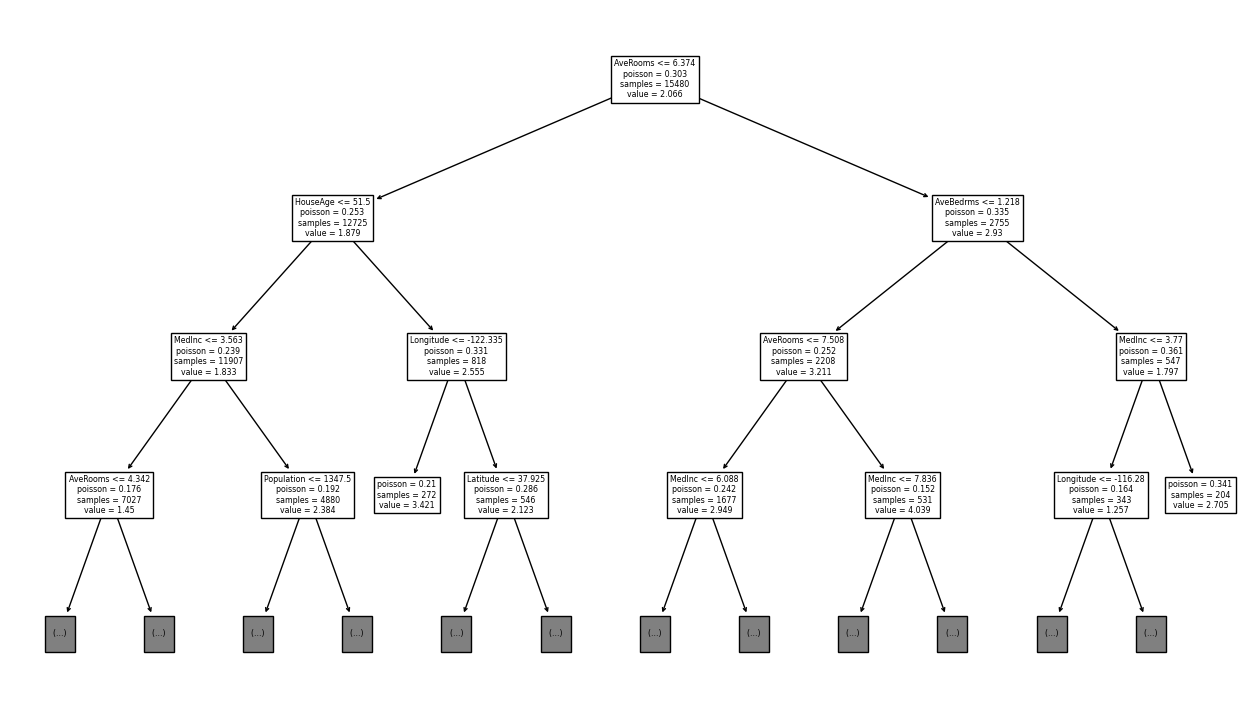

In [15]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

assert (
    X.select_dtypes(exclude=[float, int]).shape[1] == 0
), "features contain non numeric data"

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

des_tree_reg = DecisionTreeRegressor(
    criterion="poisson", min_samples_split=0.02, max_features="log2"
)
des_tree_reg.fit(X_train, y_train)

y_val_pred = des_tree_reg.predict(X_val)
print(regression_report(y_val, y_val_pred, num_feach=X.shape[1]))

plt.figure(figsize=(16, 9))
plot_tree(des_tree_reg, max_depth=3, feature_names=X.columns)
plt.show()

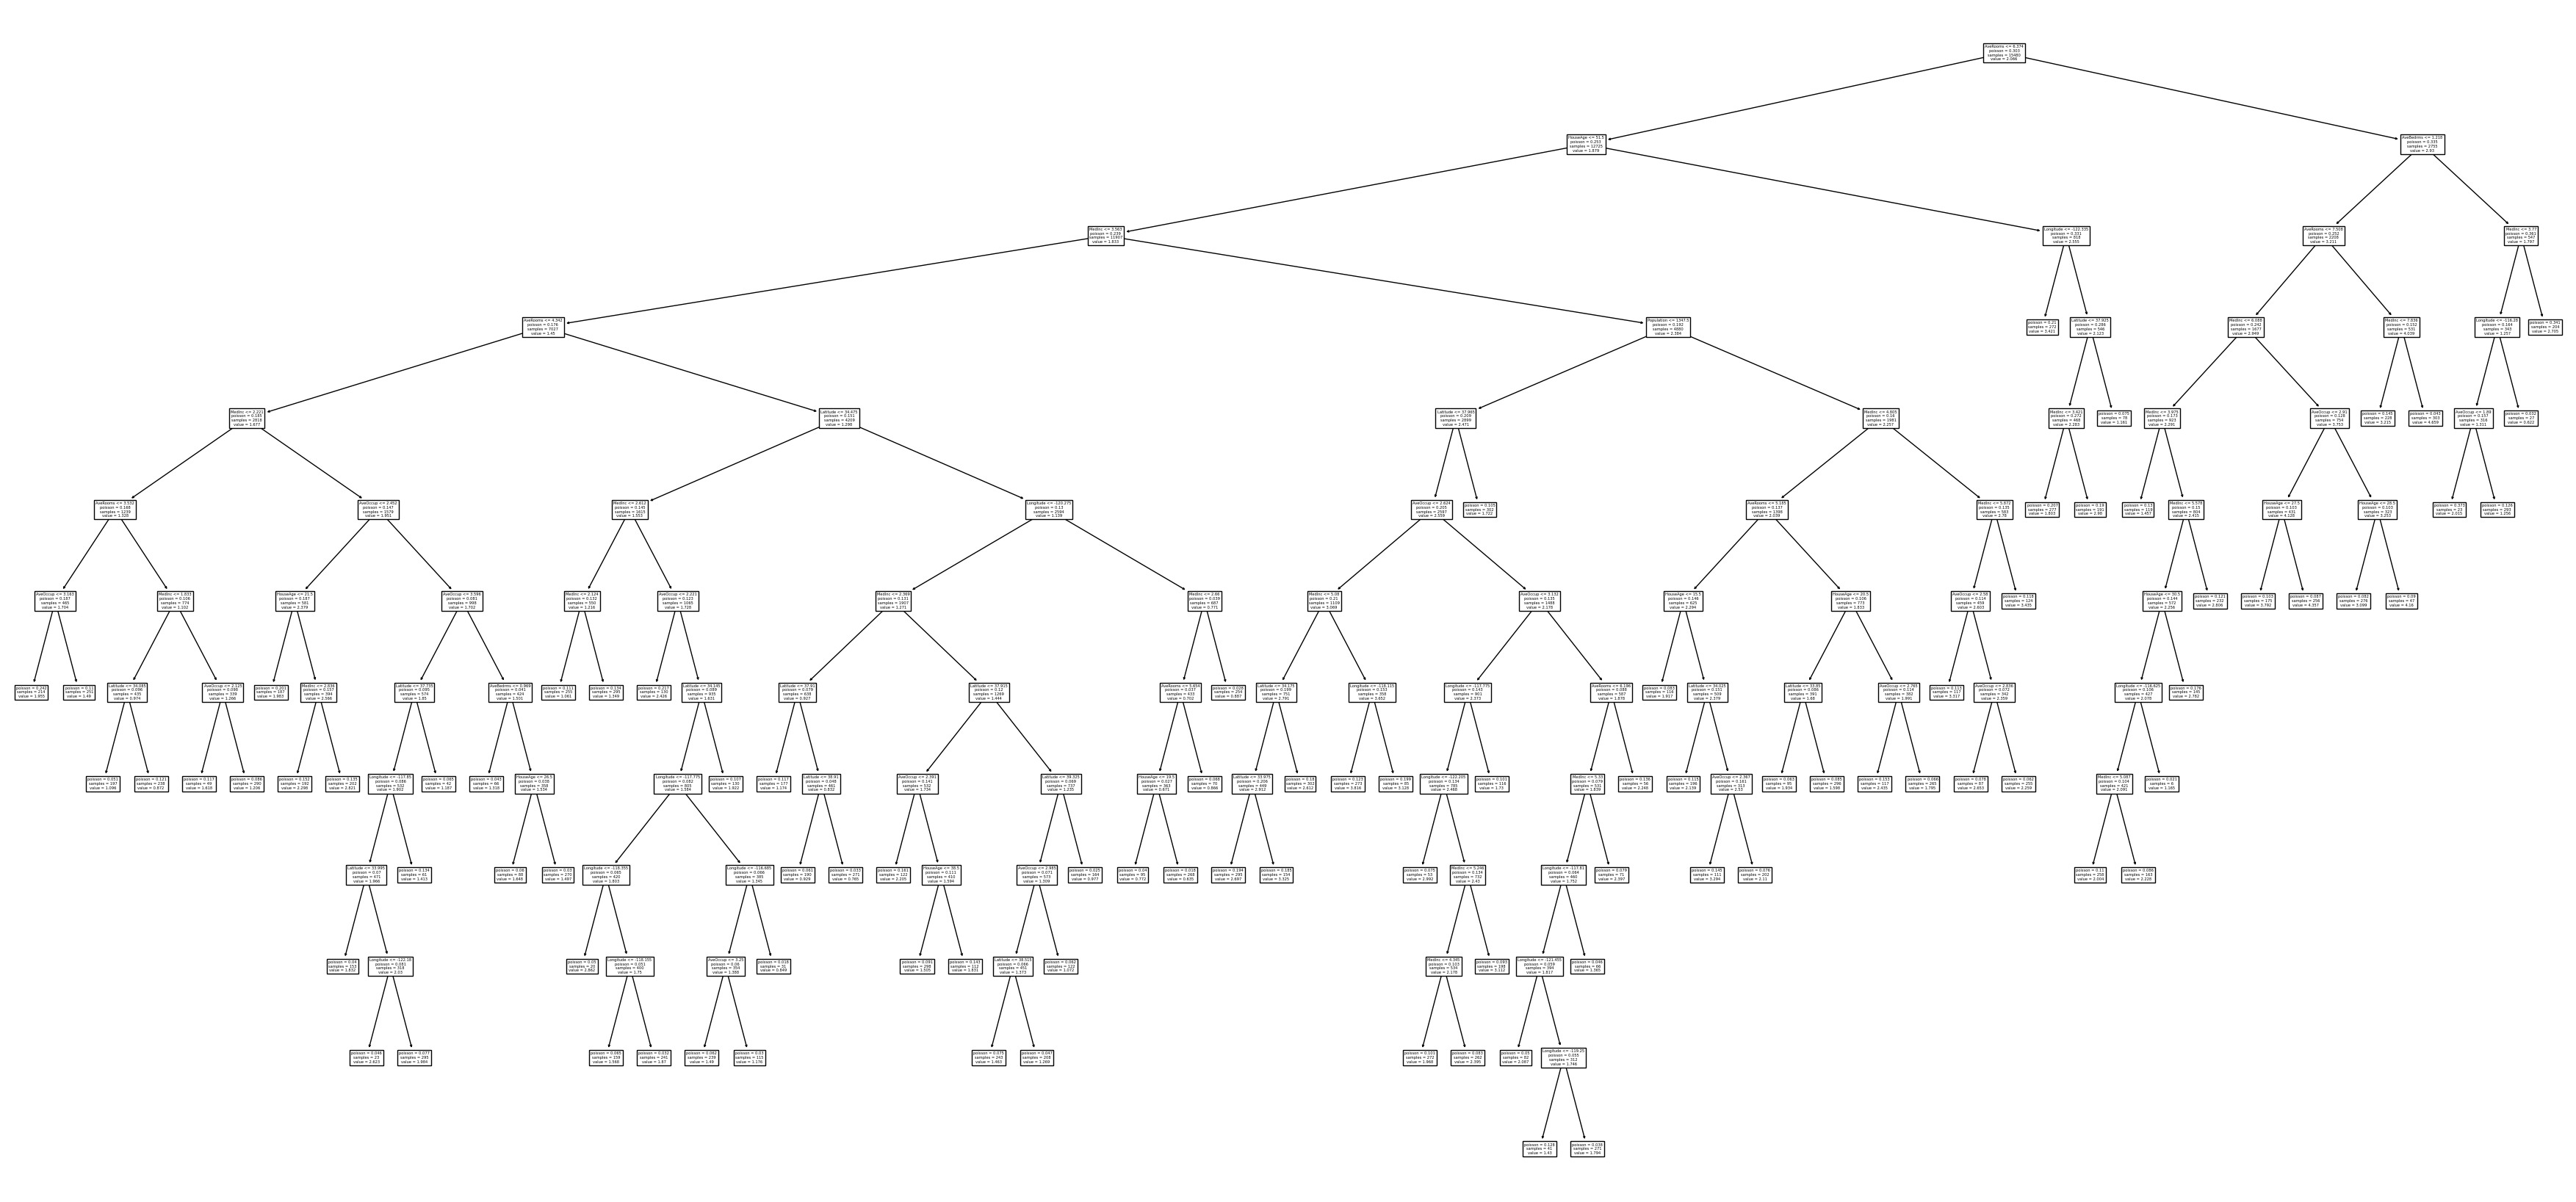

In [16]:
# full tree
plt.figure(figsize=(45, 21))
plot_tree(des_tree_reg, feature_names=X.columns)
plt.show()